In [4]:
from datetime import datetime
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import floc

from comscore.data import read_weeks_machines_domains


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
weeks_machines_domains_fpath = '../output/weeks_machines_domains.csv'

weeks_machines_domains_df = read_weeks_machines_domains(weeks_machines_domains_fpath)

reading from ../output/weeks_machines_domains.csv...
... read 4877236 rows


In [10]:
weeks_machines_domains_df.drop('machine_id', axis=1).head()

,week,n_domains,domains
0,1,104,"{moviepilot.com, pigeonsandplanes.com, reddit...."
1,1,0,{}
2,1,20,"{yahoo.com, dreamlandjewelry.com, snagajob.com..."
3,1,49,"{jenysmith.net, javhub.net, watchmygirlfriend...."
4,1,64,"{yahoo.com, arstechnica.com, ask.com, facebook..."


---

Here we sample panels which will be done in a script. We test the output.

In [12]:
# we will do the following in a script
from config import N_PANELS, COMSCORE_YEAR, N_CORES, INCOME_MAPPING
from comscore.data import read_cps_df, read_comscore_demo_df
from comscore.panel import generate_stratified_sample, stratify_cps
from comscore.utils.stratify import stratify_data_without_replacement
from joblib import Parallel, delayed

print("Reading CPS and comscore data...")
cps_df = read_cps_df(fpath="../data/CPS-race.csv")
comscore_demo_df = read_comscore_demo_df(fpath='../data/comscore/{year}/demographics.csv', year=COMSCORE_YEAR)

Reading CPS and comscore data...


In [13]:
# collapse income categories to 4 categories
cps_df['comscore_mapping'] = cps_df.comscore_mapping.apply(lambda x: INCOME_MAPPING[x])
comscore_demo_df['household_income'] = comscore_demo_df.household_income.apply(lambda x: INCOME_MAPPING[x])


In [14]:
cps_df.head()

,1,2,3,comscore_mapping,5
1,2739,1186,280,1,166
2,2154,883,107,1,151
3,4142,1274,172,1,237
4,4494,1163,214,1,176
5,4579,1070,217,1,231


In [15]:
comscore_demo_df.head()

,machine_id,household_income,racial_background
0,46569906.0,3,1.0
1,70298839.0,2,1.0
2,76984170.0,3,1.0
3,76991725.0,3,1.0
5,81191519.0,1,1.0


In [28]:
%%time

# we create stratified samples where the sampling frame is limited to machines,weeks
# with at least the threshold number of domains (7 domains for FLoC OT implementation)

N_DOMAINS_THRESHOLD = 7

comscore_sampling_frame_df = (
    weeks_machines_domains_df[weeks_machines_domains_df.n_domains >= N_DOMAINS_THRESHOLD]
    .merge(comscore_demo_df, 
               how='left', 
               left_on='machine_id', 
               right_on='machine_id')
      
)
# TODO? could maybe drop domains column
print('dropped %s - %s = %s rows to create sampling frame' % (
    len(weeks_machines_domains_df), 
    len(comscore_sampling_frame_df), 
    (len(weeks_machines_domains_df) - len(comscore_sampling_frame_df)))
)

dropped 4877236 - 2073411 = 2803825 rows to create sampling frame
CPU times: user 890 ms, sys: 92.6 ms, total: 982 ms
Wall time: 994 ms


In [29]:
comscore_sampling_frame_df.drop('machine_id', axis=1).head()

,week,n_domains,domains,household_income,racial_background
0,1,104,"{moviepilot.com, pigeonsandplanes.com, reddit....",1.0,2.0
1,1,20,"{yahoo.com, dreamlandjewelry.com, snagajob.com...",2.0,1.0
2,1,49,"{jenysmith.net, javhub.net, watchmygirlfriend....",4.0,3.0
3,1,64,"{yahoo.com, arstechnica.com, ask.com, facebook...",1.0,1.0
4,1,74,"{sling.com, adage.com, giftcardgranny.com, que...",3.0,3.0


In [30]:
import random

def generate_weekly_stratified_samples(cps_df, 
                                       comscore_sampling_frame_df, 
                                       seed_value=datetime.now()):
    """
    Creates a randomly stratified panel for each week of comscore data.
    stratification is on the joint distribution of racial background and household income
    where the distribution is determined by census CPS data.
    
    args:
    
    cps_df
    
    comscore_sampling_frame_df is a table with columns
        machine_id, week, household_income, racial_background
        where the data has been limited to a sampling frame with valid data
    """
    random.seed(seed_value)
    cps_stratify = stratify_cps(cps_df)
    comscore_sampling_frame_df['stratify'] = (
        comscore_sampling_frame_df.household_income.astype(float).astype(str) \
        + ", " \
        + comscore_sampling_frame_df.racial_background.astype(float).astype(str)
    )
    weekly_panels = []
    for week in comscore_sampling_frame_df.week.unique():
        
        comscore_week_df = comscore_sampling_frame_df[comscore_sampling_frame_df.week == week]
        demo_df_s = stratify_data_without_replacement(
            comscore_week_df, "stratify", cps_stratify.index, cps_stratify.values
        )
        weekly_panels.append(demo_df_s)
    return pd.concat(weekly_panels)

In [52]:
%%time
N_WEEKLY_PANELS = 10
all_panels = []
for p in range(N_WEEKLY_PANELS):
    print('%s/%s: generating weekly panels' % (p + 1, N_WEEKLY_PANELS))
    # each call returns 52 panels representing 1 week
    panel_weeks = generate_weekly_stratified_samples(cps_df, comscore_sampling_frame_df)
    panel_weeks['panel_id'] = panel_weeks.week + p * 52
    all_panels.append(panel_weeks)

1/10: generating weekly panels
2/10: generating weekly panels
3/10: generating weekly panels
4/10: generating weekly panels
5/10: generating weekly panels
6/10: generating weekly panels
7/10: generating weekly panels
8/10: generating weekly panels
9/10: generating weekly panels
10/10: generating weekly panels
CPU times: user 1min 6s, sys: 3.22 s, total: 1min 9s
Wall time: 1min 10s


In [53]:
all_panels_df = pd.concat(all_panels).reset_index(drop=True)

Save the panel to file.

In [58]:
all_panels_fpath = '../output/all_panels.csv'

In [59]:
print('saving all panels to file %s ...' % all_panels_fpath)
all_panels_df.drop(['domains'], axis=1).to_csv(all_panels_fpath, index=False)
print('... saved')

saving all panels to file ../output/all_panels.csv ...
... saved


### Panel testing

Read panel again

In [64]:
all_panels_df = pd.read_csv(all_panels_fpath)

Sanity checks that we did this right:

In [65]:
print('all panels: %s total rows' % len(all_panels_df))
print('%s panels' % all_panels_df.panel_id.nunique())
all_panels_df.drop(['machine_id'], axis=1).head()

all panels: 3302090 total rows
520 panels


,week,n_domains,household_income,racial_background,stratify,panel_id
0,1,11,1.0,1.0,"1.0, 1.0",1
1,1,28,1.0,1.0,"1.0, 1.0",1
2,1,7,1.0,1.0,"1.0, 1.0",1
3,1,112,1.0,1.0,"1.0, 1.0",1
4,1,61,1.0,1.0,"1.0, 1.0",1


Note that not all panels are the same size because they are sampled by week, and each week in the sampling frame has a slightly different set of users.
But we should at least expect panels for the same week to be the same size.

In [77]:
# assert all panels for the same week have the same size
week_panel_id_counts = all_panels_df.groupby('week')['panel_id'].value_counts().rename('count')
for week in all_panels_df.week.unique():
    assert(week_panel_id_counts.xs(week).nunique() == 1)

week_panel_id_counts

week  panel_id
1     1           6662
      53          6662
      105         6662
      157         6662
      209         6662
                  ... 
52    312         5261
      364         5261
      416         5261
      468         5261
      520         5261
Name: count, Length: 520, dtype: int64

Text(0, 0.5, 'panel size')

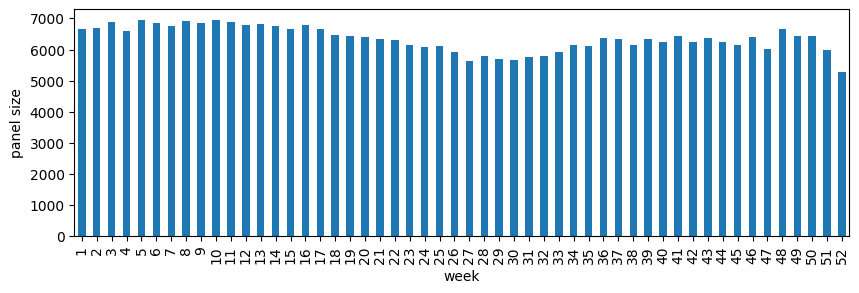

In [86]:
fig, ax = plt.subplots(1,1, figsize=(10,3), dpi=100)
week_panel_id_counts.to_frame().reset_index().drop_duplicates(
    subset=['week']
).set_index('week')['count'].plot.bar(ax=ax)
ax.set_ylabel('panel size')

In [ ]:
TODO: check the demographics distributions are correct